In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import transformers
import scipy
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from nltk.sentiment.vader import SentimentIntensityAnalyzer



### Pre-Processing 

In [443]:
philly_reviews = []
with open('../reviews/philadelphia_reviews.json') as json_data:
    data = json.load(json_data)
    count = 0 
    for val in data: 
        philly_reviews.extend(data[val])
        count += len(data[val])
        if count >= 30000: break
    philly = pd.DataFrame(philly_reviews)

In [444]:
reviews = []
with open('../reviews/santa_barbara_reviews.json') as json_data:
    data = json.load(json_data)
    count = 0
    for val in data: 
        reviews.extend(data[val][:75])
        count += len(data[val])
        if count >= 30000: break  
    sb = pd.DataFrame(reviews)

In [472]:
biz_to_cuisine = {}
def get_cuisine_biz_mapping(filename):
    with open(filename, 'r') as file:
        for line in file:
            all_businesses = json.loads(line)
            break
    for b in all_businesses.keys():
        cur = all_businesses[b]
        categories = cur['categories']
        if categories:
            categories = cur['categories'].split(",")
            for category in categories:
                cat = category.strip()
                if cat != 'Restaurants' and cat != 'Bakeries' and cat != 'Bars' and cat != 'Coffee' and cat != 'Tea' and cat !='Ethnic Food':
                    biz_to_cuisine[cur['business_id']] = cat
                    break
        else:
            biz_to_cuisine[cur['business_id']] = "None"

get_cuisine_biz_mapping('businesses/philadelphia_businesses.json')
get_cuisine_biz_mapping('businesses/santa_barbara_businesses.json')
get_cuisine_biz_mapping('businesses/indianapolis_businesses.json')
get_cuisine_biz_mapping('businesses/new_orleans_businesses.json')
get_cuisine_biz_mapping('businesses/tampa_businesses.json')

        


## Model 1: Text Classification (Emotion)

### Visualizations

In [446]:
with open('sentiment_classifications/philly_emotion_classification.json') as json_data:
    data = json.load(json_data)
    philly_emotion = pd.DataFrame(data)

with open('sentiment_classifications/sb_emotion_classification.json') as json_data:
    data = json.load(json_data)
    sb_emotion = pd.DataFrame(data)


In [480]:
with open('sentiment_classifications/indianapolis_emotion_classification.json') as json_data:
    data = json.load(json_data)
    indy_emotion = pd.DataFrame(data)

with open('sentiment_classifications/new_orleans_emotion_classification.json') as json_data:
    data = json.load(json_data)
    newo_emotion = pd.DataFrame(data)

with open('sentiment_classifications/tampa_emotion_classification.json') as json_data:
    data = json.load(json_data)
    tampa_emotion = pd.DataFrame(data)



In [481]:
def generate_cuisine_col(city_df):
    cuisines = []
    for index, row in city_df.iterrows():
        if row['business_id'] in biz_to_cuisine:
            cuisines.append(biz_to_cuisine[row['business_id']])
        else:
            cuisines.append("None")
    city_df['cuisine'] = cuisines
    
generate_cuisine_col(philly_emotion)
generate_cuisine_col(sb_emotion)
generate_cuisine_col(tampa_emotion)
generate_cuisine_col(newo_emotion)
generate_cuisine_col(indy_emotion)


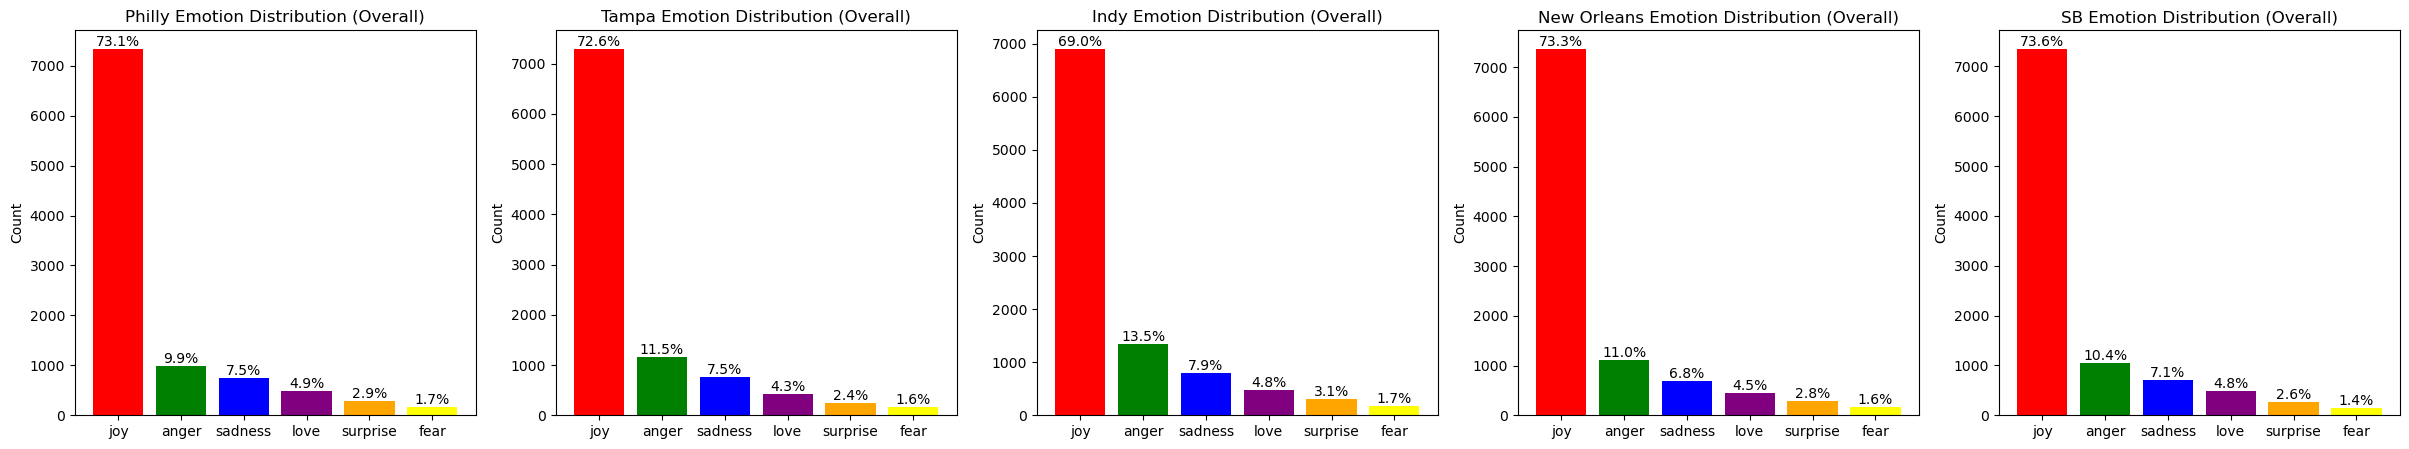

In [482]:
cities = [philly_emotion,tampa_emotion, indy_emotion , newo_emotion, sb_emotion]
names = ['Philly', 'Tampa', 'Indy','New Orleans', 'SB', ]
fig, axes = plt.subplots(ncols=5, nrows = 1, figsize=(30, 5))

for x in range(len(cities)):
    counts = cities[x]['classification'].value_counts()
    category_percentages = counts / len(cities[x]) * 100
    bars = axes[x].bar(counts.index, counts, color=['red', 'green', 'blue', 'purple','orange','yellow'])
    for bar, percentage in zip(bars, category_percentages):
        yval = bar.get_height()
        axes[x].text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')
    title = names[x]+' Emotion Distribution (Overall)'
    axes[x].set_title(title)
    axes[x].set_ylabel('Count')

plt.show()
plt.close()


In [484]:
def get_cuisine_visualization(cuisine):
    cities = [philly_emotion, sb_emotion, tampa_emotion, newo_emotion, indy_emotion]
    names = ['Philly', 'SB', 'Tampa', 'New Orleans', 'Indy']
    fig2, axes2 = plt.subplots(ncols=5, nrows = 1, figsize=(30, 5))
    query_string = "cuisine=='"+cuisine+"'"
    for x in range(len(cities)):
        temp = cities[x].query(query_string)
        counts = temp['classification'].value_counts()
        category_percentages = counts / len(temp) * 100
        bars = axes2[x].bar(counts.index, counts, color=['red', 'green', 'blue', 'purple','orange','yellow'])
        for bar, percentage in zip(bars, category_percentages):
            yval =bar.get_height()
            axes2[x].text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')
        title = names[x]+' Emotion Distribution: '+cuisine
        axes2[x].set_title(title)
        axes2[x].set_ylabel('Count')
    plt.show()
    plt.close()



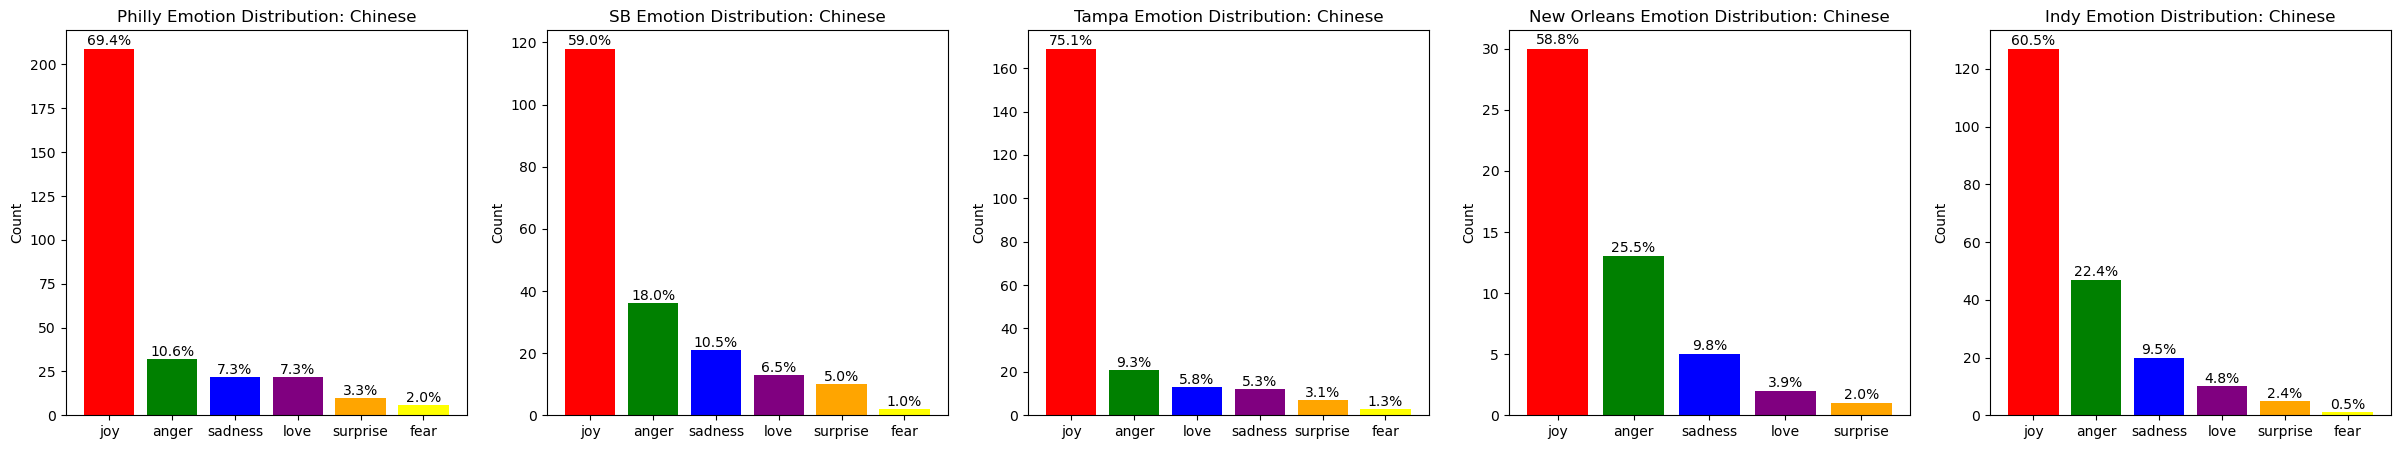

In [485]:
get_cuisine_visualization('Chinese')

In [ ]:
def chi_square_check(citya_positive, cityb_positive):
    a_pos, a_neg = citya_positive, 100-citya_positive
    b_pos, b_neg = cityb_positive, 100-cityb_positive
    observed_data = np.array([[a_pos, a_neg],
                            [b_pos, b_neg]])
    chi2, p, dof, expected = chi2_contingency(observed_data)
    #print(f"Chi-Square Value: {chi2}")
    #print(f"P-Value: {p}")
    return p
    #print(f"Degrees of Freedom: {dof}")
    #print("Contingency Table:")
    #print(expected) 

In [487]:
def z_test(title,data_size, sample_neg_ratio, population_proportion):
    neg_ratio = sample_neg_ratio*data_size 
    z_statistic, p_value = proportions_ztest(neg_ratio, data_size, population_proportion, alternative="larger")
    print("----------------------------------")
    print("RESULTS FOR:", title)
    print(f"Z-statistic: {z_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05 :
        print("The null hypothesis is rejected.")
        print("There is a significant difference in the population proportion of angry reviews and the proportion of angry reviews for Chinese restaurants.")
    else:
        print("The null hypothesis cannot be rejected.")
        print("There is no significant difference in the population proportion of angry reviews and the proportion of angry reviews for Chinese restaurants.")

z_test("PHILADELPHIA", len(philly_emotion.query("cuisine=='Chinese'")), 0.106, 0.099)
z_test("SANTA BARBARA", len(sb_emotion.query("cuisine=='Chinese'")), 0.18, 0.115)
z_test("TAMPA", len(tampa_emotion.query("cuisine=='Chinese'")), 0.093, 0.115)
z_test("NEW ORLEANS",  len(newo_emotion.query("cuisine=='Chinese'")), 0.255, 0.11)
z_test("INDIANAPOLIS",  len(indy_emotion.query("cuisine=='Chinese'")), 0.224, 0.135)

----------------------------------
RESULTS FOR: PHILADELPHIA
Z-statistic: 0.3945114349388324
P-value: 0.3466017432539455
The null hypothesis cannot be rejected.
There is no significant difference in the population proportion of angry reviews and the proportion of angry reviews for Chinese restaurants.
----------------------------------
RESULTS FOR: SANTA BARBARA
Z-statistic: 2.392683064955008
P-value: 0.008362840963096758
The null hypothesis is rejected.
There is a significant difference in the population proportion of angry reviews and the proportion of angry reviews for Chinese restaurants.
----------------------------------
RESULTS FOR: TAMPA
Z-statistic: -1.136236724492493
P-value: 0.8720712477218057
The null hypothesis cannot be rejected.
There is no significant difference in the population proportion of angry reviews and the proportion of angry reviews for Chinese restaurants.
----------------------------------
RESULTS FOR: NEW ORLEANS
Z-statistic: 2.3757725695052176
P-value: 0.0

# Model 2: Text Classification (Positive/Negative)

In [69]:
def create_posneg_dfs(filename):
    with open(filename) as json_data:
        data = json.load(json_data)
        df = pd.DataFrame(data)
    df["classification"]= df.apply(lambda x: x['classification'].replace('LABEL_1', "Positive"), axis=1)
    df["classification"]= df.apply(lambda x: x['classification'].replace('LABEL_0', "Negative"), axis=1)
    return df
philly_revs = create_posneg_dfs('sentiment_classifications/philadelphia_review_classification.json')
sb_revs = create_posneg_dfs('sentiment_classifications/sb_review_classification.json')
indy_revs = create_posneg_dfs('sentiment_classifications/indianapolis_review_classification.json')
tampa_revs = create_posneg_dfs('sentiment_classifications/tampa_review_classification.json')
newo_revs = create_posneg_dfs('sentiment_classifications/new_orleans_review_classification.json')



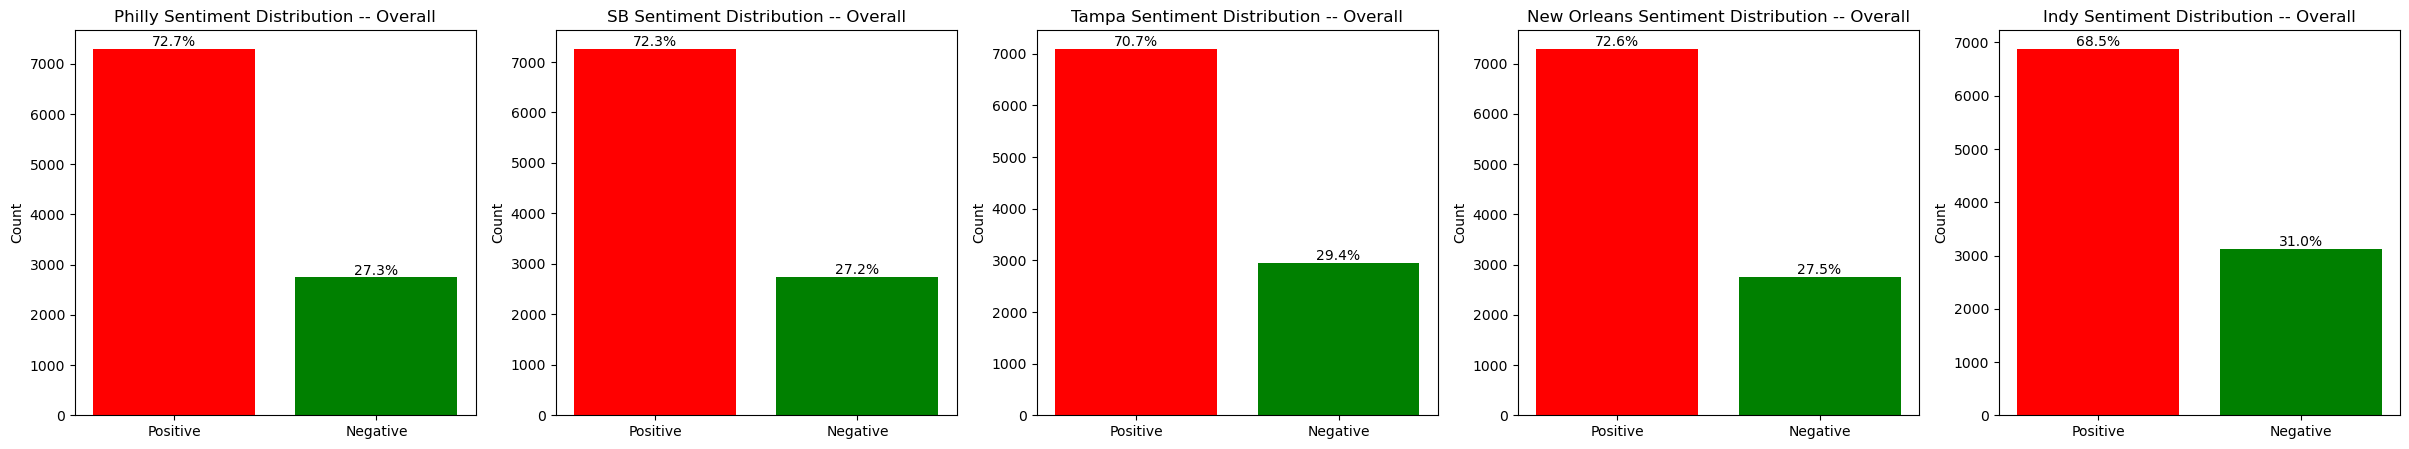

In [108]:
def overall_posneg():
    cities = [philly_revs, sb_revs, tampa_revs, newo_revs, indy_revs]
    names = ['Philly', 'Tampa', 'Indy','New Orleans', 'SB', ]
    fig2, axes2 = plt.subplots(ncols=5, nrows = 1, figsize=(30, 5))
    for x in range(len(cities)):
        counts = cities[x]['classification'].value_counts()
        category_percentages = counts / len(philly) * 100
        bars = axes2[x].bar(counts.index, counts, color=['red', 'green', 'blue', 'purple','orange','yellow'])
        for bar, percentage in zip(bars, category_percentages):
            yval = bar.get_height()
            axes2[x].text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')
        title =str(names[x])+' Sentiment Distribution -- Overall'
        axes2[x].set_title(title)
        axes2[x].set_ylabel('Count')
    plt.show()
overall_posneg()


In [75]:
generate_cuisine_col(philly_revs)
generate_cuisine_col(sb_revs)
generate_cuisine_col(tampa_revs)
generate_cuisine_col(indy_revs)
generate_cuisine_col(newo_revs)

In [93]:
print(len(sb_revs.query("cuisine=='Chinese'")))

200


In [76]:
def get_cuisine_visualization_posneg(cuisine):
    cities = [philly_revs, sb_revs, tampa_revs, newo_revs, indy_revs]
    names = ['Philly', 'Tampa', 'Indy','New Orleans', 'SB', ]
    fig2, axes2 = plt.subplots(ncols=5, nrows = 1, figsize=(30, 5))
    query_string = "cuisine=='"+cuisine+"'"
    for x in range(len(cities)):
        temp = cities[x].query(query_string)
        counts = temp['classification'].value_counts()
        category_percentages = counts / len(temp) * 100
        bars = axes2[x].bar(counts.index, counts, color=['red', 'green'])
        for bar, percentage in zip(bars, category_percentages):
            yval =bar.get_height()
            axes2[x].text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{percentage:.1f}%', ha='center', va='bottom')
        title = names[x]+' PosNeg Distribution: '+cuisine
        axes2[x].set_title(title)
        axes2[x].set_ylabel('Count')
    plt.show()
    plt.close()


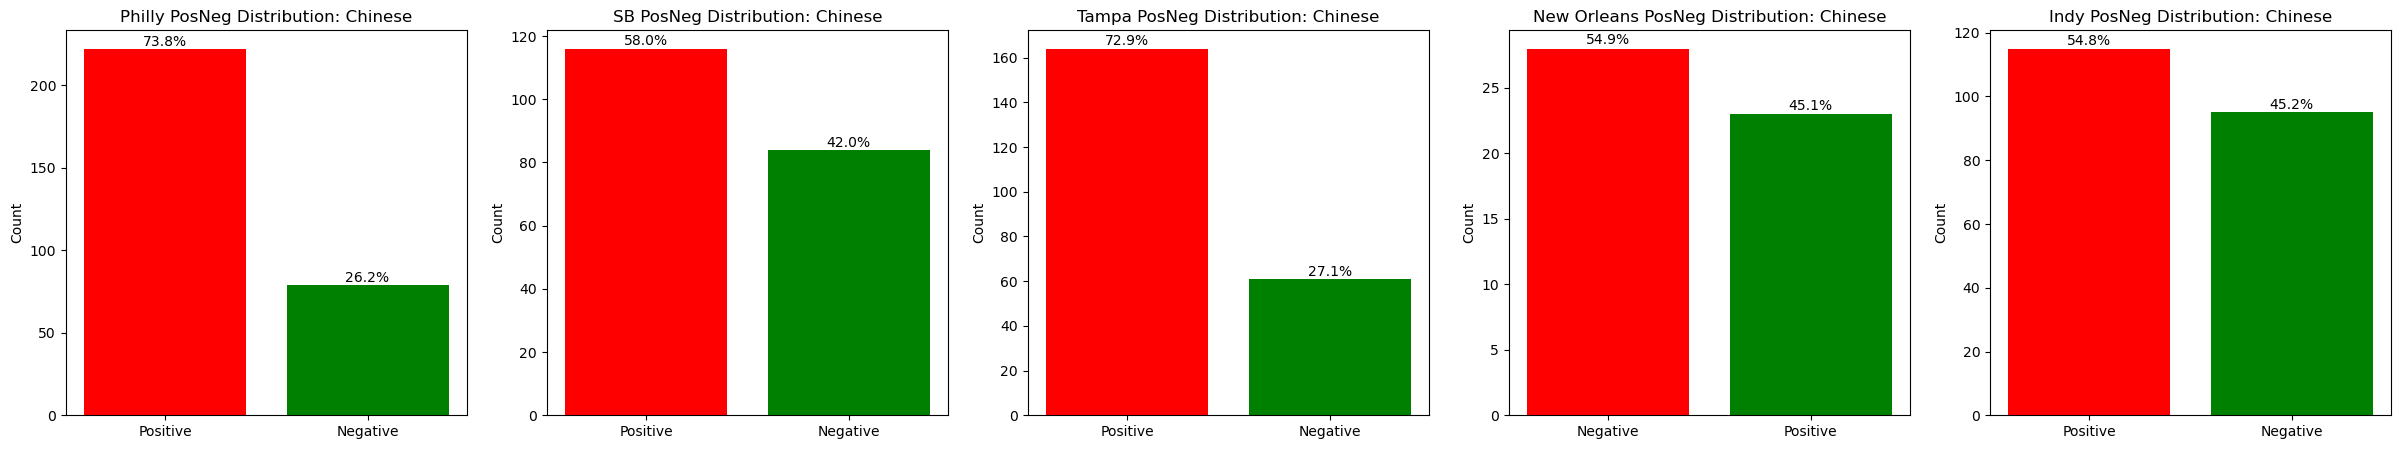

In [77]:
get_cuisine_visualization_posneg("Chinese")

## Testing

#### Chi-Square Between Cities

In [132]:
def chi_square_check(citya_positive, cityb_positive):
    a_pos, a_neg = citya_positive, 100-citya_positive
    b_pos, b_neg = cityb_positive, 100-cityb_positive
    observed_data = np.array([[a_pos, a_neg],
                            [b_pos, b_neg]])
    chi2, p, dof, expected = chi2_contingency(observed_data)
    #print(f"Chi-Square Value: {chi2}")
    #print(f"P-Value: {p}")
    return p
    #print(f"Degrees of Freedom: {dof}")
    #print("Contingency Table:")
    #print(expected) 

In [192]:
#FOR CHINESE
negative_scores = {"SB":[42,27.3], "PH":[26.2, 27.4], "TMP":[27.1, 29.4], "NO":[45.1, 27.5], "IND":[45.2,31]}
cities = ["PH",  "TMP",  "IND","NO","SB",]
chi_square_p_vals = []
for city1 in cities:
    p_vals = []
    for city2 in cities:
        if negative_scores[city1]==negative_scores[city2]: p_vals.append("1.000")
        else: 
            if chi_square_check(negative_scores[city1][0], negative_scores[city2][0]) == 1.0: p_vals.append("1.000")
            else:p_vals.append(round(chi_square_check(negative_scores[city1][0], negative_scores[city2][0]),3))
    chi_square_p_vals.append(p_vals)

print("     PH    ", "SB    ", "TMP   ", "NO   ", " IND   ")
for row in range(len(chi_square_p_vals)):
    space = " "*(5-len(cities[row]))
    print(cities[row]+space, end='')
    print(*chi_square_p_vals[row],sep="  "),
    print(" ")

     PH     SB     TMP    NO     IND   
PH   1.000  0.027  1.000  0.008  0.008
 
SB   0.027  1.000  0.039  0.765  0.754
 
TMP  1.000  0.039  1.000  0.012  0.012
 
NO   0.008  0.765  0.012  1.000  1.000
 
IND  0.008  0.754  0.012  1.000  1.000
 


In [201]:
#FOR OVERALL 
chi_square_p_vals = []
for city1 in cities:
    p_vals = []
    for city2 in cities:
        if negative_scores[city1]==negative_scores[city2]: p_vals.append("1.00")
        else: 
            if chi_square_check(negative_scores[city1][1], negative_scores[city2][1])==1.0:p_vals.append("1.00") 
            else:p_vals.append(round(chi_square_check(negative_scores[city1][1], negative_scores[city2][1]),2))
    chi_square_p_vals.append(p_vals)

print("     PH   ", " SB    ", "TMP   ", "NO    ", "IND   ")
for row in range(len(chi_square_p_vals)):
    space = " "*(5-len(cities[row]))
    print(cities[row]+space, end='')
    print(*chi_square_p_vals[row],sep="   "),
    print(" ")

     PH     SB     TMP    NO     IND   
PH   1.00   1.00   0.88   1.00   0.69
 
SB   1.00   1.00   0.86   1.00   0.67
 
TMP  0.88   0.86   1.00   0.89   0.93
 
NO   1.00   1.00   0.89   1.00   0.7
 
IND  0.69   0.67   0.93   0.7   1.00
 


#### Pearson Correlation Coefficient, Diversity Index (DI) and Negative Reviews for Chinese Restaurants

In [214]:
alpha = 0.05
#philly, sb, tampa, newor, indy
neg_review_ratio = [26.2, 42.0, 27.1, 45.1, 45.2]
div = [0.689562, 0.55874, 0.68144, 0.56415, 0.62]
correlation, p_value = scipy.stats.pearsonr(neg_review_ratio, div)
print("Correlation coefficient: ",correlation)
print("P-value: ", p_value)
if p_value >= alpha:
    print("We fail to reject the null hypothesis: There is no significant relationship between the diversity index (DI) of a city and its negative review ratio for Chinese restaurants")
else:
    if correlation < 0: 
        print("We reject the null hypothesis.")
        print("There is a negative relationship between the diversity index (DI) of a city and its negative review ratio for Chinese restaurants. ")
    else:
        print("We reject the null hypothesis.")
        print("There is a positive linear relationship between the diversity index (DI) of a city and its negative review ratio for Chinese restaurants'i'.")

Correlation coefficient:  -0.8838230772705964
P-value:  0.046697854236814426
We reject the null hypothesis.
There is a negative relationship between the diversity index (DI) of a city and its negative review ratio for Chinese restaurants. 
0.175


#### One Proportion Z-Tests (Negative Sentiment for Chinese Restaurants vs Overall)

In [210]:

def z_test(title,data_size, sample_neg_ratio, population_proportion):
    neg_ratio = sample_neg_ratio*data_size 
    z_statistic, p_value = proportions_ztest(neg_ratio, data_size, population_proportion)
    print("----------------------------------")
    print("RESULTS FOR:", title)
    print(f"Z-statistic: {z_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05 :
        print("The null hypothesis is rejected.")
        print("There is a significant difference in the population proportion of negative results and the proportion of negative results for Chinese restaurants.")
    else:
        print("The null hypothesis cannot be rejected.")
        print("There is no significant difference in the population proportion of negative results and the proportion of negative results for Chinese restaurants.")

z_test("PHILADELPHIA", len(philly_revs.query("cuisine=='Chinese'")), 0.262, 0.273)
z_test("SANTA BARBARA", len(sb_revs.query("cuisine=='Chinese'")), 0.42, 0.274)
z_test("TAMPA", len(tampa_revs.query("cuisine=='Chinese'")), 0.271, 0.294)
z_test("NEW ORLEANS",  len(newo_revs.query("cuisine=='Chinese'")), 0.451, 0.275)
z_test("INDIANAPOLIS",  len(indy_revs.query("cuisine=='Chinese'")), 0.452, 0.31)

----------------------------------
RESULTS FOR: PHILADELPHIA
Z-statistic: -0.43400737193181965
P-value: 0.6642830877759449
The null hypothesis cannot be rejected.
There is no significant difference in the population proportion of negative results and the proportion of negative results for Chinese restaurants.
----------------------------------
RESULTS FOR: SANTA BARBARA
Z-statistic: 4.183398261947144
P-value: 2.8718364119367953e-05
The null hypothesis is rejected.
There is a significant difference in the population proportion of negative results and the proportion of negative results for Chinese restaurants.
----------------------------------
RESULTS FOR: TAMPA
Z-statistic: -0.7761947223504488
P-value: 0.43763402177949373
The null hypothesis cannot be rejected.
There is no significant difference in the population proportion of negative results and the proportion of negative results for Chinese restaurants.
----------------------------------
RESULTS FOR: NEW ORLEANS
Z-statistic: 2.52594

# Model 3: VADER with NLTK

### Visualizations

In [335]:
def visualize_polarity_scores(query):
    cities = [philly_revs, sb_revs, tampa_revs, newo_revs, indy_revs]
    names = ['Philly','Tampa', 'Indy','New Orleans', 'SB']
    fig2, axes2 = plt.subplots(ncols=5, nrows = 2, figsize=(50, 30))
    for x in range(len(cities)):
        sid = SentimentIntensityAnalyzer()
        subset_scorings = []
        overall_scorings = []
        for index, row in cities[x].query(query).iterrows(): subset_scorings.append(sid.polarity_scores(row['text'])['compound'])
        for index, row in cities[x].iterrows(): overall_scorings.append(sid.polarity_scores(row['text'])['compound'])

        sns.violinplot(x=subset_scorings, color='skyblue', ax=axes2[0,x])
        axes2[0,x].set_title(names[x]+': Chinese Restaurant Sentiment Scores Distribution')
        axes2[0,x].set_xlabel('Sentiment Scores')

        sns.violinplot(x=overall_scorings, color='plum', ax=axes2[1,x])
        axes2[1,x].set_title(names[x]+': Overall Sentiment Scores Distribution')
        axes2[1,x].set_xlabel('Sentiment Scores')
    plt.show()

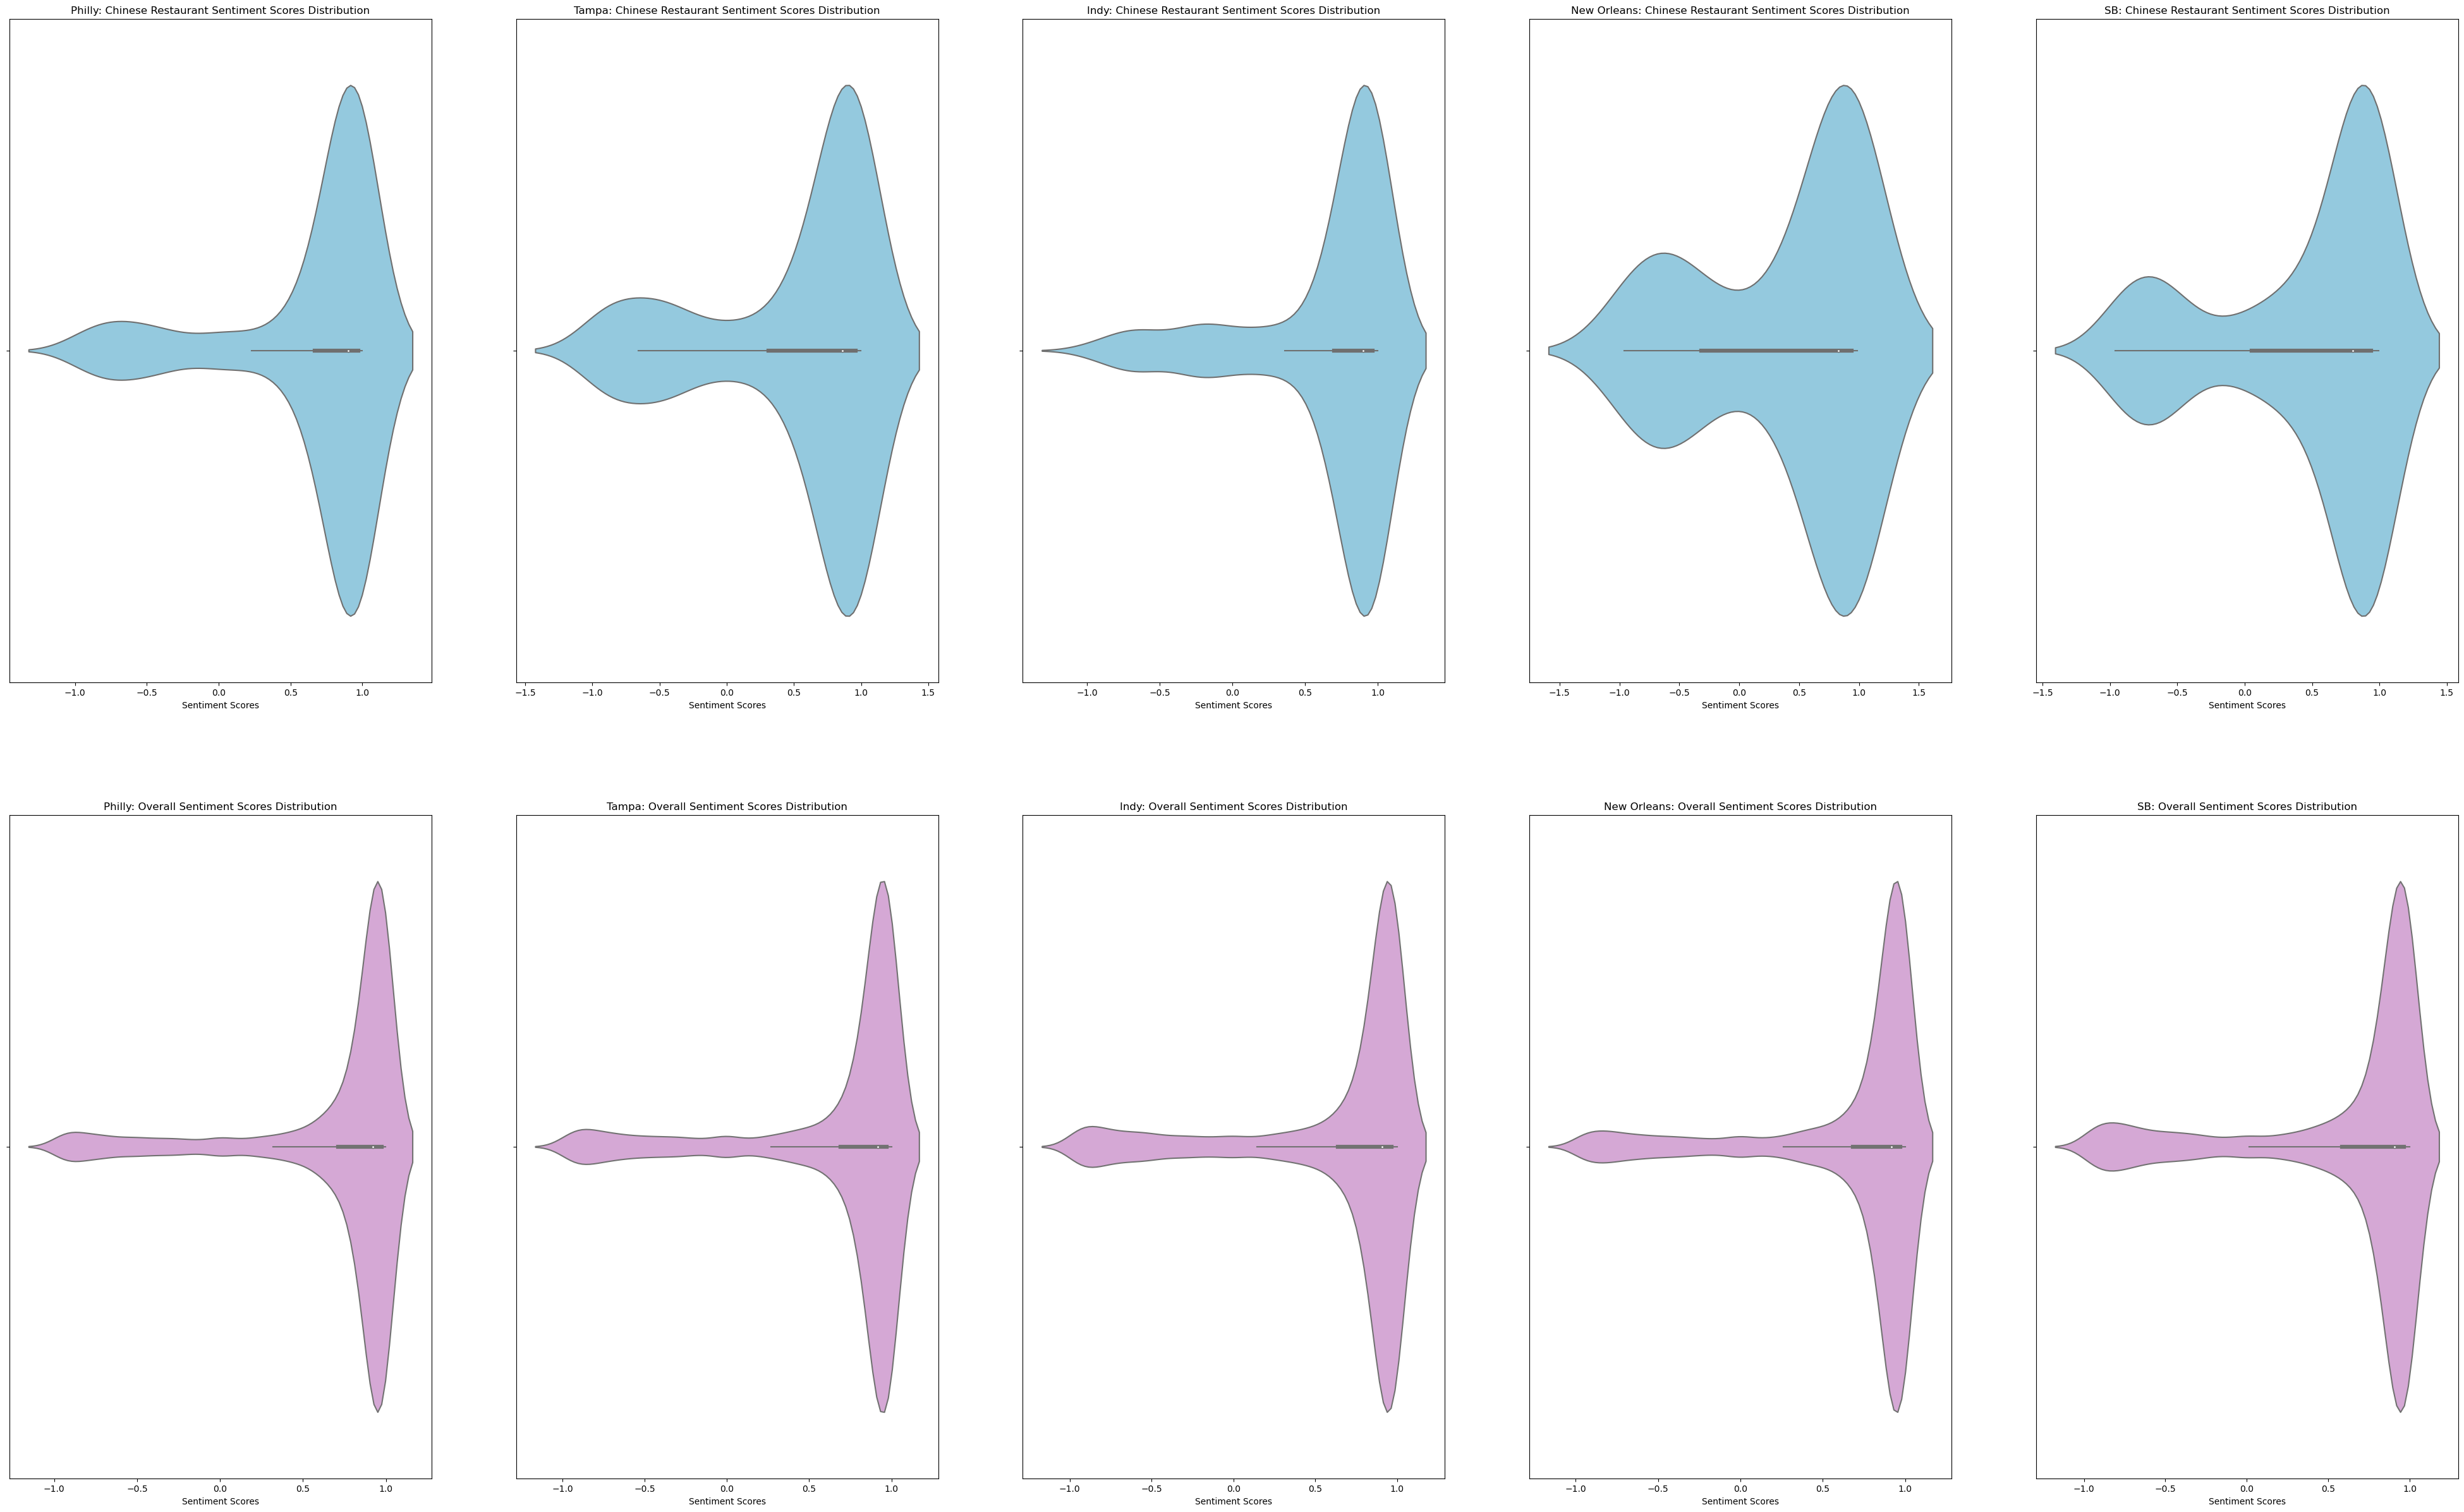

In [336]:
visualize_polarity_scores("cuisine=='Chinese'" )

### Testing

In [277]:
sid = SentimentIntensityAnalyzer()
def polarity_t_test(name, df1, df2, query, g1):
    subset1 = df1.query(query)
    subset2 = df2.query(query)
    scorings1 = []
    scorings2 = []
    for index, row in subset1.iterrows(): scorings1.append(sid.polarity_scores(row['text'])['compound'])
    for index, row in subset2.iterrows(): scorings2.append(sid.polarity_scores(row['text'])['compound'])
    t_statistic, p_value = scipy.stats.ttest_ind(scorings1, scorings2, equal_var = False, alternative='greater')
    alpha = 0.05
    if p_value < alpha:
        print(name+"Reject the null hypothesis. There is evidence that the mean sentiment of",g1,"is greater. p-val: ", p_value)
    else:
        print(name+"Fail to reject the null hypothesis. The sentiment is not significantly different. p-val: ", p_value)
print("PHILADELPHIA VS. ")
polarity_t_test("Tampa: ", philly_revs,tampa_revs, "cuisine=='Chinese'", 'Philly')
polarity_t_test("SB: ", philly_revs,sb_revs, "cuisine=='Chinese'", 'Philly' )
polarity_t_test("Indy: ", philly_revs,indy_revs, "cuisine=='Chinese'", 'Philly' )
polarity_t_test("NewO: ", philly_revs,newo_revs, "cuisine=='Chinese'" , 'Philly')
print("-----------------------------------------------------")
print("SB VS. ")
polarity_t_test("Tampa: ", tampa_revs,sb_revs, "cuisine=='Chinese'", 'Tampa' )
polarity_t_test("Indy: ",sb_revs,indy_revs, "cuisine=='Chinese'", 'SB' )
polarity_t_test("NewO: ",sb_revs,newo_revs, "cuisine=='Chinese'", 'New Orleans')
print("-----------------------------------------------------")
print("TAMPA VS. ")
polarity_t_test("Indy: ",tampa_revs,indy_revs, "cuisine=='Chinese'" , 'Tampa')
polarity_t_test("NewO: ",tampa_revs,newo_revs, "cuisine=='Chinese'", 'Tampa' )
print("-----------------------------------------------------")
print("NEW ORLEANS VS. ")
polarity_t_test("Indy: ",newo_revs,indy_revs, "cuisine=='Chinese'",'New Orleans' )


PHILADELPHIA VS. 
Tampa: Fail to reject the null hypothesis. The sentiment is not significantly different. p-val:  0.6923036965964579
SB: Reject the null hypothesis. There is evidence that the mean sentiment of Philly is greater. p-val:  0.012558368055929761
Indy: Reject the null hypothesis. There is evidence that the mean sentiment of Philly is greater. p-val:  0.00022518084797909407
NewO: Reject the null hypothesis. There is evidence that the mean sentiment of Philly is greater. p-val:  0.012697148675783244
-----------------------------------------------------
SB VS. 
Tampa: Reject the null hypothesis. There is evidence that the mean sentiment of Tampa is greater. p-val:  0.004373366242384097
Indy: Fail to reject the null hypothesis. The sentiment is not significantly different. p-val:  0.12734308712300701
NewO: Fail to reject the null hypothesis. The sentiment is not significantly different. p-val:  0.1505936409711519
-----------------------------------------------------
TAMPA VS. 
